In [1]:
import os
import random
import shutil

# Define paths to your dataset
biodegradable_dir = r"C:\Datasets\Garbage\b"
non_biodegradable_dir = r"C:\Datasets\Garbage\n"

# Define paths for training and test directories
train_dir = 'train'
test_dir = 'test'

# Create directories for training and test sets
os.makedirs(os.path.join(train_dir, 'b'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'n'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'b'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'n'), exist_ok=True)

# Function to move images to their respective directories
def move_images(image_list, source_dir, destination_dir):
    for img_path in image_list:
        img_name = os.path.basename(img_path)
        source_path = os.path.join(source_dir, img_name)
        destination_path = os.path.join(destination_dir, img_name)
        shutil.move(source_path, destination_path)

# List all image files in the biodegradable and non-biodegradable directories
biodegradable_images = [os.path.join(biodegradable_dir, img) for img in os.listdir(biodegradable_dir)]
non_biodegradable_images = [os.path.join(non_biodegradable_dir, img) for img in os.listdir(non_biodegradable_dir)]

# Shuffle the lists to randomize the order of images
random.shuffle(biodegradable_images)
random.shuffle(non_biodegradable_images)

# Define ratio for splitting data into training and test sets
test_ratio = 0.2  # 20% for test, 80% for training

# Calculate number of images for each class in the test set
biodegradable_test_count = int(len(biodegradable_images) * test_ratio)
non_biodegradable_test_count = int(len(non_biodegradable_images) * test_ratio)

# Split the lists into training and test sets
biodegradable_test_images = biodegradable_images[:biodegradable_test_count]
non_biodegradable_test_images = non_biodegradable_images[:non_biodegradable_test_count]

# Move images to their respective directories for test set
move_images(biodegradable_test_images, biodegradable_dir, os.path.join(test_dir, 'b'))
move_images(non_biodegradable_test_images, non_biodegradable_dir, os.path.join(test_dir, 'n'))

# Move the remaining images to training directories
move_images(biodegradable_images[biodegradable_test_count:], biodegradable_dir, os.path.join(train_dir, 'b'))
move_images(non_biodegradable_images[non_biodegradable_test_count:], non_biodegradable_dir, os.path.join(train_dir, 'n'))

print("Data split and moved successfully!")


Data split and moved successfully!


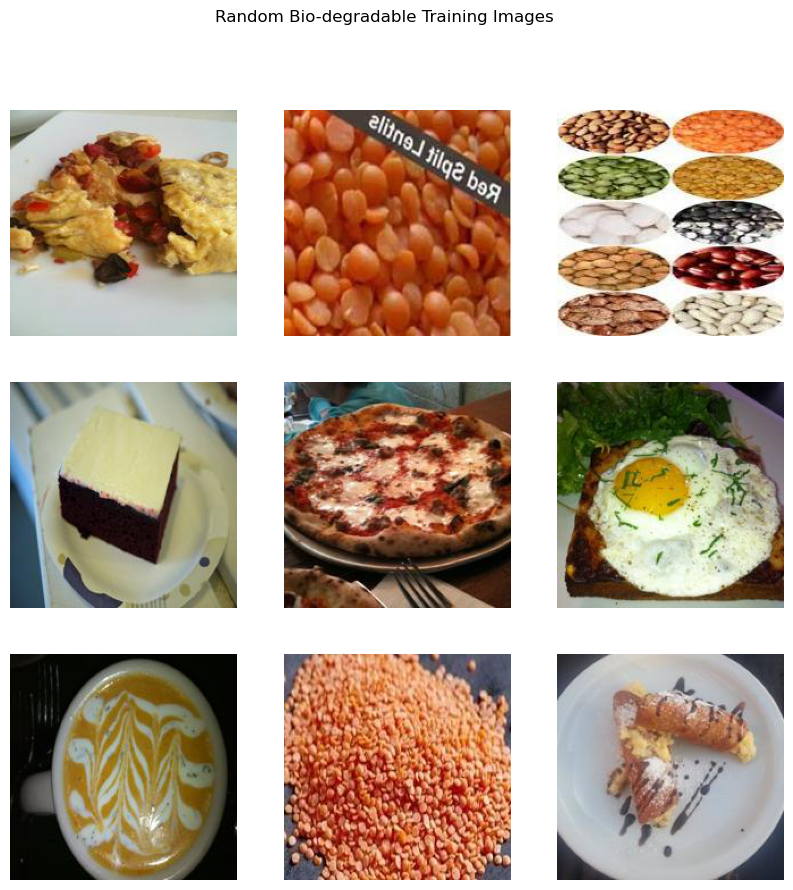

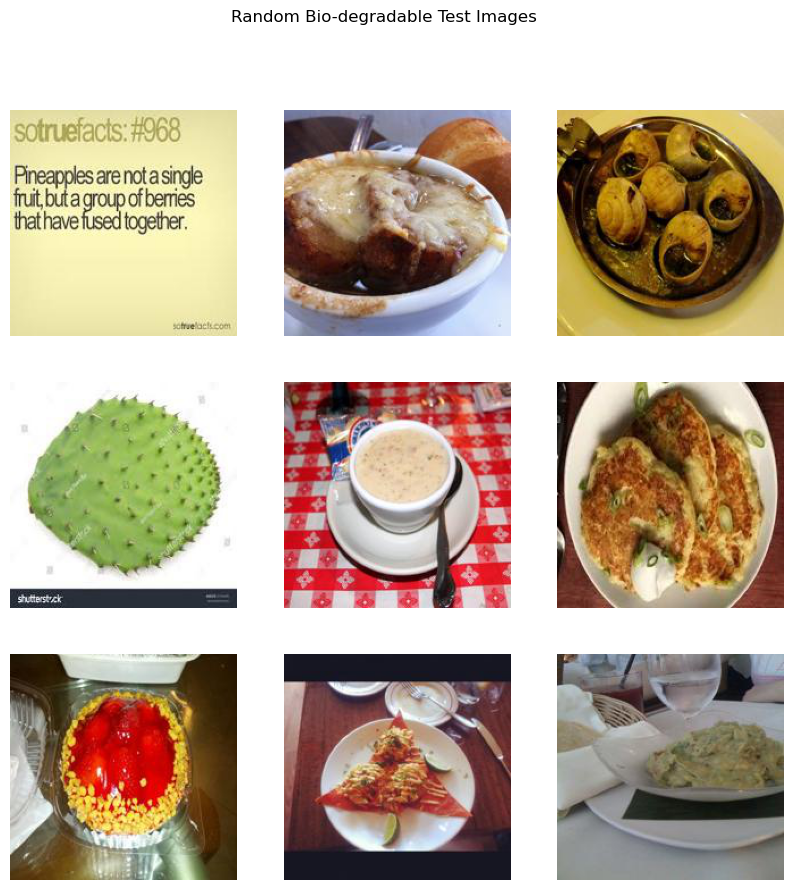

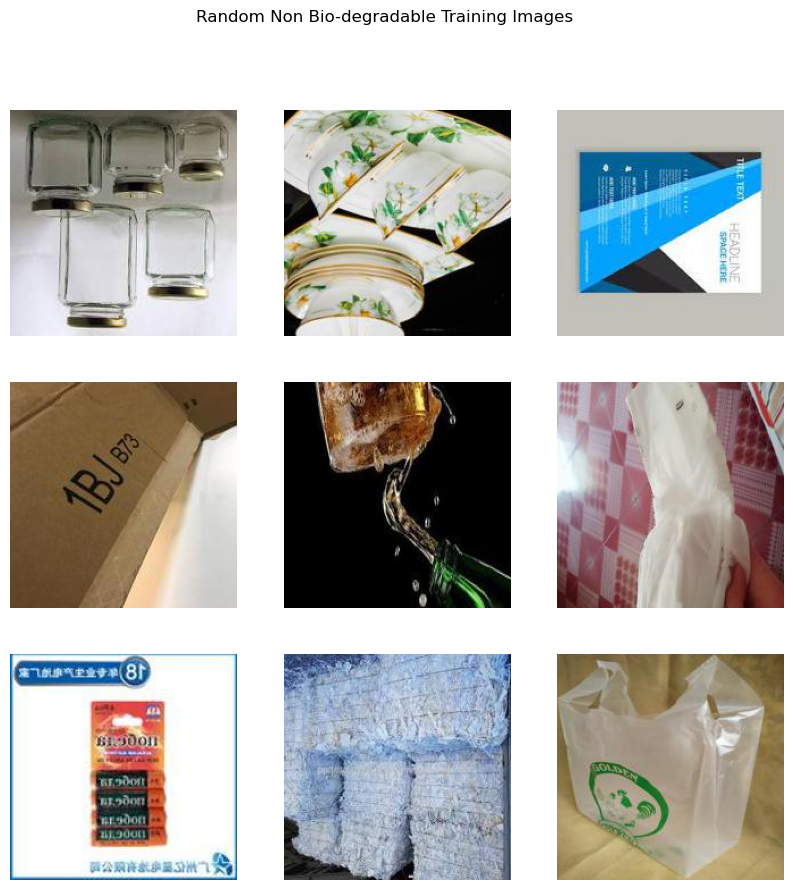

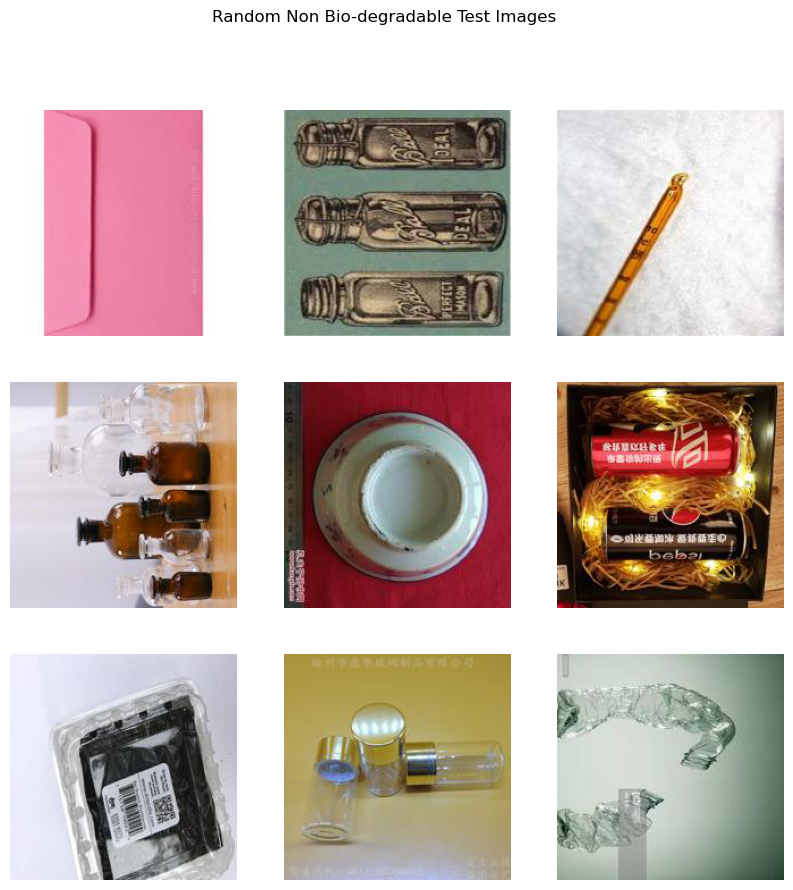

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths to directories containing bio and non-bio images
train_bio_dir = r"E:\Binary Writing\archgarbage\train\b"
test_bio_dir = r"E:\Binary Writing\archgarbage\test\b"
train_non_bio_dir = r"E:\Binary Writing\archgarbage\train\n"
test_non_bio_dir = r"E:\Binary Writing\archgarbage\test\n"

# Function to display random images from each class and dataset
def display_random_images(image_dir, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        img_name = random.choice(os.listdir(image_dir))
        img_path = os.path.join(image_dir, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display random images from training and test datasets for bio and non-bio classes
display_random_images(train_bio_dir, 'Random Bio-degradable Training Images')
display_random_images(test_bio_dir, 'Random Bio-degradable Test Images')
display_random_images(train_non_bio_dir, 'Random Non Bio-degradable Training Images')
display_random_images(test_non_bio_dir, 'Random Non Bio-degradable Test Images')


In [13]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define paths to directories containing bio and non-bio images
train_dir = r"E:\Binary Writing\archgarbage\train"
test_dir = r"E:\Binary Writing\archgarbage\test"


# Define data augmentation parameters including contrast adjustment
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_width, img_height = 224, 224
batch_size = 32

# Data Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1. / 255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

# Flow validation images in batches using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')


Found 105863 images belonging to 2 classes.
Found 26465 images belonging to 2 classes.


In [14]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

# Load the pre-trained VGG16 model (excluding the top fully connected layers)
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

# Freeze the convolutional layers so that their weights are not updated during training
for layer in vgg16_base.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base
model = Sequential()
model.add(vgg16_base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification (bio/non-bio)


In [15]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
               loss='binary_crossentropy', 
               metrics=['accuracy'])


In [17]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    epochs=1,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size)


3308/3308 [==============================] - 12846s 4s/step - loss: 0.2176 - accuracy: 0.9159 - val_loss: 0.1559 - val_accuracy: 0.9366


In [22]:
# Get the final training and validation accuracy
train_accuracy = history.history['accuracy'][-1]
val_accuracy = history.history['val_accuracy'][-1]

# Get the final training and validation loss
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

# Print the final training and validation accuracy
print(f'Final training accuracy: {train_accuracy:.4f}')
print(f'Final validation accuracy: {val_accuracy:.4f}')

# Print the final training and validation loss
print(f'Final training loss: {train_loss:.4f}')
print(f'Final validation loss: {val_loss:.4f}')


Final training accuracy: 0.9159
Final validation accuracy: 0.9366
Final training loss: 0.2176
Final validation loss: 0.1559


In [18]:
# Define the path to save the model
model_path = 'vgg16_model.h5'

# Save the model
model.save(model_path)

print("Model saved successfully.")


c:\Users\sound\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved successfully.


In [2]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('vgg16_model.h5')

# Define image dimensions
img_width, img_height = 224, 224

# Function to preprocess image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((img_width, img_height))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to predict image
def predict_image():
    # Open file dialog to select image
    file_path = filedialog.askopenfilename()
    if file_path:
        # Preprocess the selected image
        img_array = preprocess_image(file_path)
        
        # Make prediction
        prediction = model.predict(img_array)
        
        # Display prediction result
        if prediction[0][0] > 0.5:
            result_label.config(text="Predicted class: Non Bio-degradable")
        else:
            result_label.config(text="Predicted class: Bio-degradable")
        
        # Display the selected image
        img = Image.open(file_path)
        img.thumbnail((300, 300))
        img = ImageTk.PhotoImage(img)
        image_label.config(image=img)
        image_label.image = img

# Create GUI window
root = tk.Tk()
root.title("Image Classifier")

# Create widgets
select_button = tk.Button(root, text="Select Image", command=predict_image)
select_button.pack(pady=10)

result_label = tk.Label(root, text="")
result_label.pack(pady=5)

image_label = tk.Label(root)
image_label.pack(pady=10)

# Run the GUI
root.mainloop()


1/1 [==============================] - 0s 230ms/step
